# SQLalchemy Homework - Surf's Up! - Terrence Cummings

In [60]:
#Dependencies, libraries, and imports
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

#SQLalchemy libraries and functions
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, MetaData
from sqlalchemy import Column, Integer, String, Float
from sqlalchemy.ext.declarative import declarative_base

#VROOM, VROOM!
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


## Step 1 - Climate Analysis and Observation
1. Inspect tables
2. Automap and assign to classes
3. Save CSV's for checking

In [61]:
#Use inspector find table and columns in database
inspector = inspect(engine)
tables_found = inspector.get_table_names()
num_tables_found = len(tables_found)

for table in tables_found:
    columns = inspector.get_columns(table)
    print("")
    print("Table: "+table)
    for column in columns:
        print(column["name"], column["type"])
    


Table: measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

Table: station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [62]:
#Use automap to get table structures and reflect into classes
Base = automap_base()
Base.prepare(engine, reflect=True)

#See what classes have been created. Classes created should match tables found by Inspector
classes_created = Base.classes.keys()
print(classes_created)

#Single variable to represent each Class associated with the automapped Base
Measurement = Base.classes.measurement
Station = Base.classes.station

#Classes are now all setup. Start query session.
session = Session(engine)

#Write classes to dataframes and csv's for checking
measurement_query = session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs)
measurement_df = pd.DataFrame(measurement_query, columns = ['id', 'station', 'date', 'prcp', 'tobs'])
measurement_df.set_index('id', inplace=True)
measurement_df.to_csv('measurement.csv')

station_query = session.query(Station.id, Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation)
station_df = pd.DataFrame(station_query, columns = ['id', 'station', 'name', 'latitude', 'longitude', 'elevation'])
station_df.set_index('id', inplace=True)
station_df.to_csv('station.csv')


['measurement', 'station']


## Precipitation Analysis
1. Calculate earliest, latest, and year-from-latest dates for precipitation analysis
2. Make dataframe of last year's precipitation
3. Group by data and take the max precip on each date
4. Make bar chart of max precipitation on each day of last year

In [63]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

#Find the earliest date in the Measurement table by query. Convert to python dictionary, read date as text, convert to datetime.
earliest_date_query = session.query(Measurement.date).order_by(Measurement.date).first()
ed_dict=earliest_date_query._asdict()
earliest_date = ed_dict['date']
earliest_date_dt = dt.datetime.strptime(earliest_date, "%Y-%m-%d")

#Find the latest date in the Measurement table by query. Convert to python dictionary, read date as text, convert to datetime.
latest_date_query = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
ld_dict=latest_date_query._asdict()
latest_date = ld_dict['date']
latest_date_dt = dt.datetime.strptime(latest_date, "%Y-%m-%d")

# Calculate the date 1 year ago from the latest data point in the database
year_ago_latest_dt = latest_date_dt - dt.timedelta(days=365)
year_ago_latest = dt.datetime.strftime(year_ago_latest_dt, "%Y-%m-%d")

#Perform a query to retrieve the date and precipitation over prior year from the latest date
date_prcp_query = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date<=latest_date_dt).filter(Measurement.date>=year_ago_latest_dt)

#Save the query results as a Pandas DataFrame and set the index to the date column
date_prcp_df = pd.DataFrame(date_prcp_query, columns=['Date', 'Precipitation'])
date_prcp_df.set_index('Date', inplace=True)

#Drop NaN's and sort the dataframe by date
date_prcp_df.dropna(inplace=True)
date_prcp_df.sort_index(inplace=True)


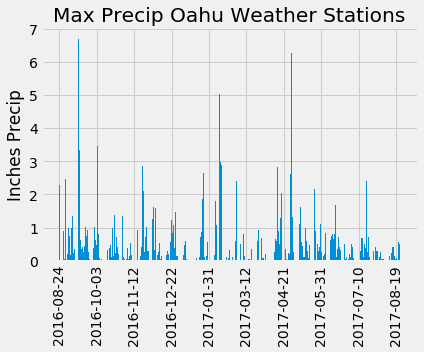

In [64]:

#Data contains precipitation readings from numerous Oahu weather stations on the same dates.
#Use the max precipitation recorded at any weather station on a date as data to plot.abs
#Groupby date and take the max precipitaiton reading on that date.
date_prcp_max = date_prcp_df.groupby('Date')[['Precipitation']].max()


#Plot x index (date) y (max precip on that date)
x = date_prcp_max.index
y = date_prcp_max['Precipitation']

fig, ax = plt.subplots()
ax.bar(x, y)

#Space x ticks and labels so they are readable
ax.set_xticks(x[::40])
ax.set_xticklabels(x[::40], rotation=90)
plt.ylabel('Inches Precip')
plt.title('Max Precip Oahu Weather Stations')
plt.show()


In [65]:
#Use Pandas to calcualte the summary statistics for the precipitation data plotted above
print(date_prcp_max.describe())

Precipitation
count     365.000000
mean        0.517288
std         0.829196
min         0.000000
25%         0.040000
50%         0.250000
75%         0.650000
max         6.700000


## Station Analysis
1. Find how many stations are in the data
2. Find the weather station with the most number of observations. Temperature data will be used from this station.
3. Calc the max, min, and avg temperature for this station.
4. Plot histogram of temp readings from this station.

In [66]:
# Design a query to show how many stations are available in this dataset. Confirm same answer from both tables.
stat_cnt_meas = session.query(Measurement.station).group_by(Measurement.station).count()
stat_cnt_stat = session.query(Station.station).group_by(Station.station).count()
print(stat_cnt_meas)
print(stat_cnt_stat)

9
9


In [67]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stat_freq = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print("List of stations and number of observations = ")
print(stat_freq)

#Set variabel for the station id with the most observations
max_stat_freq = stat_freq[0][0]
print("")
print("Station with most observations = "+max_stat_freq)


List of stations and number of observations = 
[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]

Station with most observations = USC00519281


In [68]:
# Using the station id from the previous query, calculate the lowest temp recorded, 
# highest temp recorded, and average temp of the most active station?
max_temp_max_stat = session.query(Measurement.station, func.max(Measurement.tobs)).filter(Measurement.station==max_stat_freq).all()
min_temp_max_stat = session.query(Measurement.station, func.min(Measurement.tobs)).filter(Measurement.station==max_stat_freq).all()
avg_temp_max_stat = session.query(Measurement.station, func.avg(Measurement.tobs)).filter(Measurement.station==max_stat_freq).all()

print("Max temp")
print(max_temp_max_stat)
print("Min temp")
print(min_temp_max_stat)
print("Avg temp")
print(avg_temp_max_stat)


Max temp
[('USC00519281', 85.0)]
Min temp
[('USC00519281', 54.0)]
Avg temp
[('USC00519281', 71.66378066378067)]


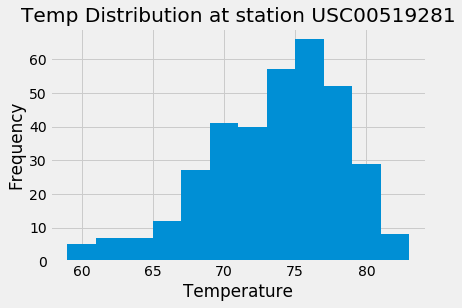

In [69]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_query = session.query(Measurement.tobs).\
    filter(Measurement.date<=latest_date_dt).filter(Measurement.date>=year_ago_latest_dt).\
    filter(Measurement.station==max_stat_freq)

# Save the query results as a Pandas DataFrame
tobs_df = pd.DataFrame(tobs_query, columns=['tobs'])
tobs_df.dropna(inplace=True)

#Plot histogram of temperature readings at weahter station with the most readings.
tobs_df.hist(bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temp Distribution at station '+max_stat_freq)
plt.show()

## Bonus Challenge Assignment

In [70]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
       
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
start_date = '2012-02-28'
end_date = '2012-03-05'
min_temp_orig = calc_temps(start_date, end_date)[0][0]
avg_temp_orig = calc_temps(start_date, end_date)[0][1]
maxi_temp_orig = calc_temps(start_date, end_date)[0][2]
print(f'Start date: {start_date}, End date: {end_date}')
print(f'Min temp: {min_temp_orig}, Avg temp: {avg_temp_orig}, Max temp: {maxi_temp_orig}')

Start date: 2012-02-28, End date: 2012-03-05
Min temp: 62.0, Avg temp: 69.57142857142857, Max temp: 74.0


In [71]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
prior_year_start = str(int(start_date[:4])-1)+start_date[4:]
prior_year_end = str(int(end_date[:4])-1)+end_date[4:]

min_temp_prior = calc_temps(prior_year_start, prior_year_end)[0][0]
avg_temp_prior = calc_temps(prior_year_start, prior_year_end)[0][1]
maxi_temp_prior = calc_temps(prior_year_start, prior_year_end)[0][2]
print(f'Start date: {prior_year_start}, End date: {prior_year_end}')
print(f'Min temp: {min_temp_prior}, Avg temp: {avg_temp_prior}, Max temp: {maxi_temp_prior}')

Start date: 2011-02-28, End date: 2011-03-05
Min temp: 61.0, Avg temp: 69.75510204081633, Max temp: 75.0


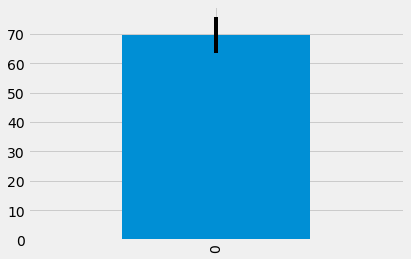

In [72]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerror = (maxi_temp_orig - min_temp_orig)/2

fig, ax = plt.subplots()
df = pd.DataFrame({"Avgtemp":[avg_temp_orig],"error":[yerror]})
meansum = df["Avgtemp"]
stdsum = df["error"]

plot = meansum.plot(kind='bar',yerr=stdsum)
plt.show()


In [81]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

stat_prcp_dates = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).join(Station, Station.station == Measurement.station).group_by(Measurement.station).filter(Measurement.date >= prior_year_start).filter(Measurement.date <= prior_year_end).order_by(func.sum(Measurement.prcp).desc()).all()

stat_prcp_dates_df = pd.DataFrame(stat_prcp_dates, columns = ['station', 'name', 'latitude', 'longitude', 'elevation', 'tot prcp'])
stat_prcp_dates_df

,station,name,latitude,longitude,elevation,tot prcp
0,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6,2.33
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,2.23
2,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,2.19
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.96
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,1.45
5,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,1.44
6,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,1.38
7,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,0.63
8,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN


In [82]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [97]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date_dt = dt.datetime.strptime(start_date, "%Y-%m-%d")
end_date_dt = dt.datetime.strptime(end_date, "%Y-%m-%d")

normals_list = []
dates_list = []

ddd = start_date_dt
while ddd<=end_date_dt:
    xxx = dt.datetime.strftime(ddd, "%m-%d")
    yyy = dt.datetime.strftime(ddd, "%Y-%m-%d")
    nnn = daily_normals(xxx)
    normals_list.append(nnn[0])
    dates_list.append(yyy)
    ddd = ddd + dt.timedelta(days=1)

print(normals_list)
print(dates_list)

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(65.0, 70.65517241379311, 80.0), (67.0, 71.73333333333333, 79.0), (64.0, 70.0327868852459, 76.0), (61.0, 70.36666666666666, 78.0), (60.0, 70.06896551724138, 78.0), (57.0, 69.27272727272727, 77.0), (60.0, 67.89090909090909, 76.0)]
['2012-02-28', '2012-02-29', '2012-03-01', '2012-03-02', '2012-03-03', '2012-03-04', '2012-03-05']


In [103]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals_list, columns = ['min', 'avg', 'max'], index = dates_list)
normals_df.index.name = 'trip_dates'
normals_df

,min,avg,max
trip_dates,,,
2012-02-28,65.0,70.655172,80.0
2012-02-29,67.0,71.733333,79.0
2012-03-01,64.0,70.032787,76.0
2012-03-02,61.0,70.366667,78.0
2012-03-03,60.0,70.068966,78.0
2012-03-04,57.0,69.272727,77.0
2012-03-05,60.0,67.890909,76.0


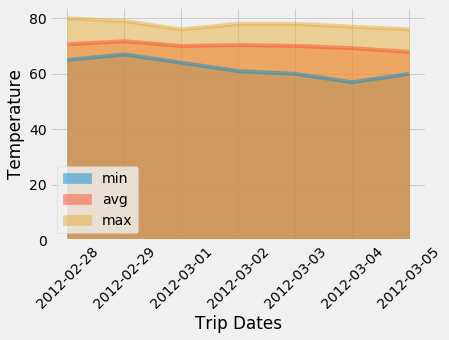

In [107]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked=False, rot = 45)
plt.xlabel('Trip Dates')
plt.ylabel('Temperature')
plt.show()